# UIDAI Data Hackathon 2026  
## Notebook 04: Cross-Dataset Analysis & Anomaly Detection

This notebook integrates enrolment, biometric update, and demographic update datasets
to identify cross-patterns, anomalies, and service demand indicators.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_context("notebook")
plt.style.use("default")

In [2]:
BASE_PATH = "/Users/aaronrao/Desktop/projects/UIDAI_Aadhaar_Data_Insights/data/processed"

biometric_df = pd.read_csv(os.path.join(BASE_PATH, "biometric_cleaned.csv"))
demographic_df = pd.read_csv(os.path.join(BASE_PATH, "demographic_cleaned.csv"))
enrolment_df = pd.read_csv(os.path.join(BASE_PATH, "enrolment_cleaned.csv"))

/var/folders/qs/5q2_h5j931g_w8krqy_fjh640000gn/T/ipykernel_54814/3433212929.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  biometric_df = pd.read_csv(os.path.join(BASE_PATH, "biometric_cleaned.csv"))
/var/folders/qs/5q2_h5j931g_w8krqy_fjh640000gn/T/ipykernel_54814/3433212929.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  demographic_df = pd.read_csv(os.path.join(BASE_PATH, "demographic_cleaned.csv"))
/var/folders/qs/5q2_h5j931g_w8krqy_fjh640000gn/T/ipykernel_54814/3433212929.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  enrolment_df = pd.read_csv(os.path.join(BASE_PATH, "enrolment_cleaned.csv"))


In [3]:
bio_district = biometric_df.groupby(
    ["state", "district"], as_index=False
)["total_biometric_updates"].sum()

demo_district = demographic_df.groupby(
    ["state", "district"], as_index=False
)["total_demographic_updates"].sum()

enrol_district = enrolment_df.groupby(
    ["state", "district"], as_index=False
)["total_enrolments"].sum()

In [4]:
merged_df = enrol_district.merge(
    bio_district, on=["state", "district"], how="left"
).merge(
    demo_district, on=["state", "district"], how="left"
)

merged_df.fillna(0, inplace=True)
merged_df.head()

,state,district,total_enrolments,total_biometric_updates,total_demographic_updates
0,100000,100000,218.0,0.0,2.0
1,Andaman & Nicobar Islands,Andamans,75.0,2015.0,750.0
2,Andaman & Nicobar Islands,Nicobars,1.0,2.0,4.0
3,Andaman & Nicobar Islands,South Andaman,38.0,367.0,305.0
4,Andaman And Nicobar Islands,Nicobar,75.0,1811.0,787.0


### 1. Enrolment vs Biometric Updates
Comparing enrolment volume with biometric update activity to identify stability
or operational stress in regions.

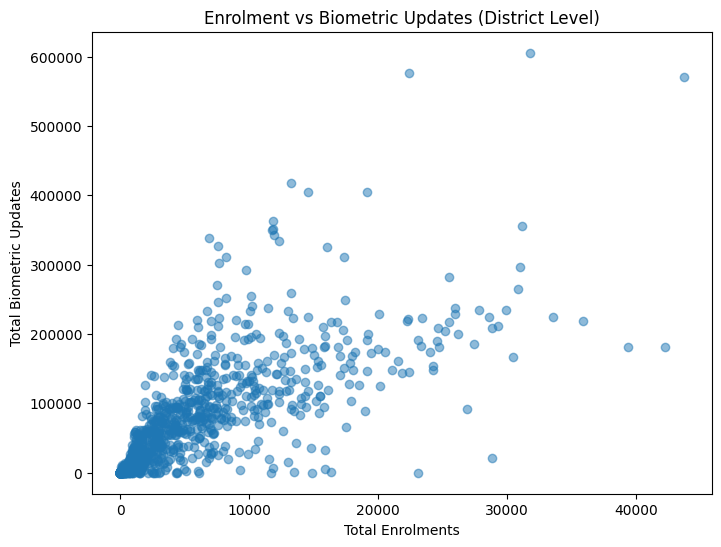

In [5]:
plt.figure(figsize=(8, 6))
plt.scatter(
    merged_df["total_enrolments"],
    merged_df["total_biometric_updates"],
    alpha=0.5
)
plt.xlabel("Total Enrolments")
plt.ylabel("Total Biometric Updates")
plt.title("Enrolment vs Biometric Updates (District Level)")
plt.show()

### 2. Enrolment vs Demographic Updates
Demographic updates act as a proxy for population mobility and life events.

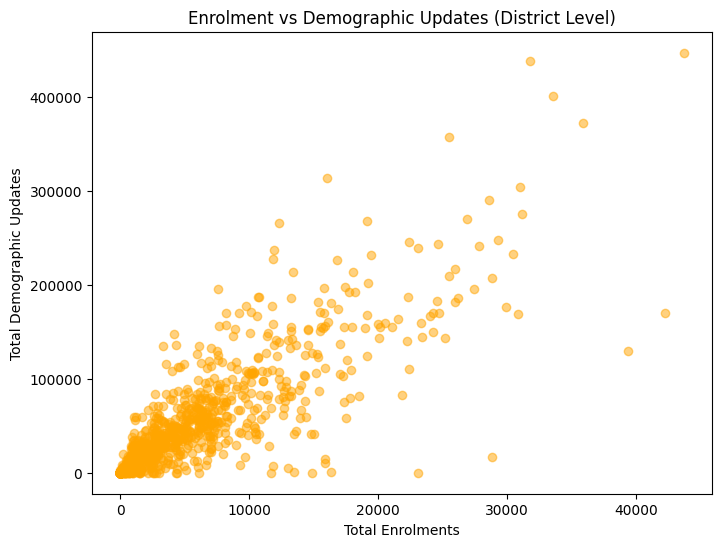

In [6]:
plt.figure(figsize=(8, 6))
plt.scatter(
    merged_df["total_enrolments"],
    merged_df["total_demographic_updates"],
    alpha=0.5,
    color="orange"
)
plt.xlabel("Total Enrolments")
plt.ylabel("Total Demographic Updates")
plt.title("Enrolment vs Demographic Updates (District Level)")
plt.show()

### 3. Anomaly Detection
Districts with disproportionately high update activity relative to enrolment
are identified using simple statistical thresholds.

In [7]:
from scipy.stats import zscore

merged_df["bio_update_z"] = zscore(merged_df["total_biometric_updates"])
merged_df["demo_update_z"] = zscore(merged_df["total_demographic_updates"])

anomalies = merged_df[
    (merged_df["bio_update_z"].abs() > 3) |
    (merged_df["demo_update_z"].abs() > 3)
]

anomalies.sort_values(
    by=["bio_update_z", "demo_update_z"],
    ascending=False
).head(10)

,state,district,total_enrolments,total_biometric_updates,total_demographic_updates,bio_update_z,demo_update_z
558,Maharashtra,Pune,31763.0,605762.0,438478.0,6.816461,6.455146
554,Maharashtra,Nashik,22368.0,576606.0,246100.0,6.447742,3.281610
567,Maharashtra,Thane,43688.0,571273.0,447253.0,6.380299,6.599901
542,Maharashtra,Jalgaon,13260.0,417384.0,151076.0,4.434155,1.714060
233,Gujarat,Ahmedabad,19130.0,405490.0,267884.0,4.283738,3.640966
546,Maharashtra,Mumbai,14552.0,404359.0,135483.0,4.269435,1.456832
520,Maharashtra,Ahmadnagar,11836.0,363561.0,227667.0,3.753487,2.977532
759,Rajasthan,Jaipur,31146.0,355884.0,275340.0,3.656400,3.763963
550,Maharashtra,Nagpur,11828.0,350923.0,158901.0,3.593661,1.843144
29,Andhra Pradesh,Kurnool,11770.0,350633.0,177645.0,3.589994,2.152352


### 4. High-Update Districts
These districts may require administrative review, additional infrastructure,
or targeted outreach.

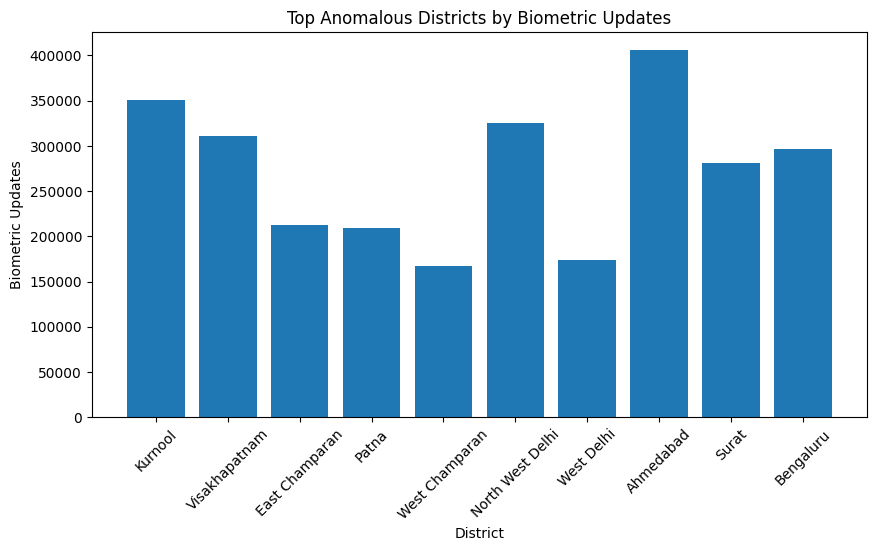

In [8]:
top_anomalies = anomalies.head(10)

plt.figure(figsize=(10, 5))
plt.bar(
    top_anomalies["district"],
    top_anomalies["total_biometric_updates"]
)
plt.title("Top Anomalous Districts by Biometric Updates")
plt.xlabel("District")
plt.ylabel("Biometric Updates")
plt.xticks(rotation=45)
plt.show()

In [9]:
OUTPUT_PATH = "/Users/aaronrao/Desktop/projects/UIDAI_Aadhaar_Data_Insights/outputs/tables"
os.makedirs(OUTPUT_PATH, exist_ok=True)

anomalies.to_csv(
    os.path.join(OUTPUT_PATH, "district_anomalies.csv"),
    index=False
)

print("Anomaly table saved successfully.")

Anomaly table saved successfully.


### Summary of Cross-Dataset Findings
- Enrolment and update behaviours vary significantly across districts.
- High update-to-enrolment ratios suggest population mobility or biometric instability.
- Identified anomalous districts can help UIDAI prioritize service interventions.

Next notebook: **05_visualisation.ipynb**